In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

# Houses Kaggle Competition (bis 🔥) 

[<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

Let's re-use our previous pipeline build in module `05-07-Ensemble-Methods` and improve final predictions using a Neural Network!

# Re-use already-built preprocessing

### Load data

In [2]:
# Let's load our training dataset
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv")
X = data.drop(columns='SalePrice')
y = data['SalePrice']

# You don't have access to y_yest! Only Kaggle has it.
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

print(X.shape, y.shape, X_test.shape)

(1460, 80) (1460,) (1459, 80)


In [33]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

### Import preprocessor

You will find in `utils/preprocessor.py` the data-preprocessing pipeline that was built in our previous iteration.

❓ Run the cell below, and make sure you understand what the pipeline does. Look at the code in `preprocessor.py`

In [3]:
from utils.preprocessor import create_preproc
preproc = create_preproc(X)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_encoder',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BedroomAbvGr',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'Fireplaces', 'FullBath',
                                                   'GarageArea', 'GarageCars...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x12e9d5430>))])

In [31]:
#!cat utils/preprocessor.py

❓ Fit the preprocessor you your train set and create your feature matrix `X_preproc` that will be used by the Neural Network

In [7]:
preproc.fit(X, y)
X_preproc = preproc.transform(X)

In [9]:
X_preproc.shape

(1460, 162)

# Your prediction in Keras

This is your first **regression** task with Keras! 
- The cell below contains compiler and fit hyper-parameters we recommend you to start with.
- Kaggle's [rule](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) requires to minimize `rmsle` (Root Mean Square Log Error). As you can see, we have been able to specify `msle` direcly as loss-function with Keras! Just remember to take square-root of your loss results to read your rmsle metric.
- The best boosted-tree `rmsle` score to beat is around **0.13**

❓ **Question** ❓
- Your responsibility is to build the best model architecture, and to control the epoch number to avoid overfitting.
- We recommand you to create a train/val split upfront to visually control the validation loss thanks to `plot_history`

In [14]:
# Create a train-val split here
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_preproc, y, test_size=0.3)

In [15]:
X_train.shape

(1022, 162)

In [16]:
from tensorflow.keras import models, layers

In [170]:
def initialize_model():

    ### YOUR MODEL ARCHITECTURE HERE
    model = models.Sequential()
    
    model.add(layers.Dense(200, activation='relu', input_dim=162))
    model.add(layers.Dense(75, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))     
    model.add(layers.Dense(25, activation='relu'))    

    model.add(layers.Dense(1, activation='linear'))

    
    # Recommended compilator
    model.compile(optimizer='adam',
                  loss='msle',
                  metrics=['msle']) # directly optimize for the squared log error!
    return model

model = initialize_model()

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=150, # Play with this until your validation loss overfit
                    batch_size=16, # Keep batch size to 16 today
                    verbose=0)

In [171]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('MSLE')
    plt.xlabel('Epoch')
    plt.ylim(0, 1)
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

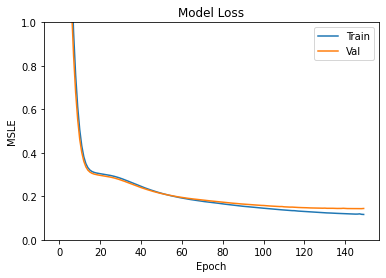

In [172]:
plot_history(history)

In [173]:
model.evaluate(X_val, y_val, verbose=0)[1] ** 0.5

0.14403414941717788

❓ **Question** ❓
- Are you satisfied with your score?
- Before you publish it, ask yourself if you can trust it entirely? Has it been cross-validated? 
- Feel free to cross-validate it manually with a for loop in python if you want before submitting to Kaggle

# 🏅FINAL SUBMISSION

Predict the house prices of your test set and submit results to kaggle! Be carefull with the format